# Disciple - 取引シミュレーション（Jupyter用）

In [1]:
import datetime
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.conv import conv_transaction_df2html
from funcs.setting import load_setting
from funcs.tide import get_date_dir_from_file
from funcs.tse import get_ticker_name_list
from modules.disciple import Disciple
from structs.res import AppRes

In [2]:
# デバッグモード
debug = True

res = AppRes()
excel = "ticks_20260120.xlsx"
# code = "7011"
# code = "7203"
code = "8306"
# code = "9984"
dict_setting = load_setting(res, code)
THRESHOLD_SLOPE = dict_setting["THRESHOLD_SLOPE"]
TURBULENCE = dict_setting["TURBULENCE"]
date_str = get_date_dir_from_file(excel)
print(date_str)

app = Disciple(excel, code, dict_setting)
app.run()

2026/01/20
パラメータ
PERIOD_WARMUP : 180
PERIOD_MA_1 : 50
PERIOD_MA_2 : 500
PERIOD_SLOPE : 5
THRESHOLD_SLOPE : 0.03
PERIOD_RR : 30
TURBULENCE : 5.0
LOSSCUT_1 : -20
THRESHOLD_PM_MIN : 15.0
THRESHOLD_DDR_MIN : 0.4
N_MINUS_MAX : 180


In [3]:
# 取引明細
df_transaction = app.getTransaction()
df_transaction["累積損益"] = df_transaction["損益"].fillna(0).cumsum()
print("取引明細")
print(df_transaction)
print(df_transaction["注文日時"].dtype)
print(df_transaction["累積損益"].dtype)

list_html = conv_transaction_df2html(df_transaction)

if debug:
    output_dir = os.path.join("tmp", date_str)
else:
    output_dir = os.path.join("output", date_str)

os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_transaction.html")
print(output)
with open(output, mode="w") as f:
    f.write("\n".join(list_html))

list_trans = df_transaction["注文日時"]
n_trade = len(df_transaction)
total = df_transaction["損益"].sum()
print(f"取引回数: {n_trade} 回 / 総収益: {total} 円/株")

取引明細
    注文番号                          注文日時 銘柄コード  売買    約定単価  約定数量     損益 備考  \
0      1 2026-01-20 09:32:49.933845043  8306  売建  2938.5   100    NaN      
1      2 2026-01-20 09:42:13.346411943  8306  買埋  2936.5   100  200.0      
2      3 2026-01-20 09:42:43.431879997  8306  売建  2935.5   100    NaN      
3      4 2026-01-20 09:51:31.226155996  8306  買埋  2932.0   100  350.0      
4      5 2026-01-20 09:56:50.584126949  8306  売建  2930.5   100    NaN      
5      6 2026-01-20 10:05:59.928905964  8306  買埋  2929.0   100  150.0      
6      7 2026-01-20 10:06:00.943368912  8306  買建  2929.0   100    NaN      
7      8 2026-01-20 10:09:02.390202045  8306  売埋  2926.5   100 -250.0      
8      9 2026-01-20 10:09:36.524243115  8306  売建  2924.0   100    NaN      
9     10 2026-01-20 10:11:03.050962925  8306  買埋  2927.0   100 -300.0      
10    11 2026-01-20 10:11:04.069108009  8306  買建  2927.0   100    NaN      
11    12 2026-01-20 10:11:30.253541946  8306  売埋  2924.5   100 -250.0      
12    1

In [4]:
# Matplotlib の共通設定
FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

In [5]:
"""
累積損益のトレンドを作成するための準備
"""

# 元データ
ts = df_transaction["注文日時"]
pl = df_transaction["累積損益"]

# 日付（年月日）だけ取り出す
date = ts.iloc[0].normalize()

# 追加する先頭と末尾の行
start_row = pd.DataFrame(
    {
        "注文日時": [date + pd.Timedelta(hours=9)],
        "累積損益": [0.0],
    }
)

end_row = pd.DataFrame(
    {
        "注文日時": [date + pd.Timedelta(hours=15, minutes=30)],
        "累積損益": [pl.iloc[-1]],
    }
)

# トレンド用 DataFrame を作成
trend_df = pd.concat(
    [start_row, df_transaction[["注文日時", "累積損益"]], end_row], ignore_index=True
)

# 注文日時を index にした Series を作成
trend_series = trend_df.set_index("注文日時")["累積損益"]
trend_series

注文日時
2026-01-20 09:00:00.000000000      0.0
2026-01-20 09:32:49.933845043      0.0
2026-01-20 09:42:13.346411943    200.0
2026-01-20 09:42:43.431879997    200.0
2026-01-20 09:51:31.226155996    550.0
2026-01-20 09:56:50.584126949    550.0
2026-01-20 10:05:59.928905964    700.0
2026-01-20 10:06:00.943368912    700.0
2026-01-20 10:09:02.390202045    450.0
2026-01-20 10:09:36.524243115    450.0
2026-01-20 10:11:03.050962925    150.0
2026-01-20 10:11:04.069108009    150.0
2026-01-20 10:11:30.253541946   -100.0
2026-01-20 10:11:31.257668018   -100.0
2026-01-20 10:18:24.305901051      0.0
2026-01-20 10:18:25.307539940      0.0
2026-01-20 10:20:07.751038074    -50.0
2026-01-20 10:25:38.409818888    -50.0
2026-01-20 10:50:15.849040031    850.0
2026-01-20 10:50:16.847472906    850.0
2026-01-20 10:53:09.600920916    650.0
2026-01-20 10:53:10.618088961    650.0
2026-01-20 10:53:29.764090061    450.0
2026-01-20 10:53:30.752727985    450.0
2026-01-20 10:55:33.133563042    250.0
2026-01-20 10:55:34.

tmp/2026/01/20/8306_trend_profit.png


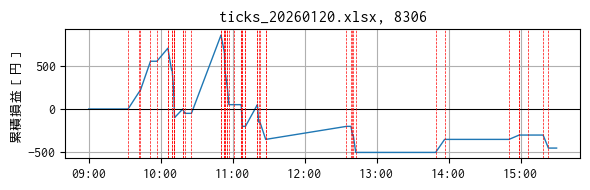

In [6]:
# 累積損益トレンド
fig, ax = plt.subplots(figsize=(6, 2))

ax.set_title(f"{excel}, {code}")
ax.plot(trend_series, linewidth=1)
ax.axhline(y=0, color="black", linewidth=0.75)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("累積損益［円］")
for t in list_trans:
    ax.axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)
ax.grid()

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_trend_profit.png")
print(output)
plt.savefig(output)
plt.show()

In [7]:
# テクニカル指標
print("テクニカル指標")
df_tech = app.getTechnicals()
print(df_tech)

テクニカル指標
                               ts   price          ma1          ma2    mr  \
2026-01-20 09:00:10  1.768867e+09  2964.5  2964.500000  2964.500000   0.0   
2026-01-20 09:00:11  1.768867e+09  2964.5  2964.500000  2964.500000   0.0   
2026-01-20 09:00:12  1.768867e+09  2959.0  2962.666667  2962.666667   5.5   
2026-01-20 09:00:13  1.768867e+09  2959.0  2961.750000  2961.750000   5.5   
2026-01-20 09:00:14  1.768867e+09  2953.5  2960.100000  2960.100000  11.0   
...                           ...     ...          ...          ...   ...   
2026-01-20 15:24:45  1.768890e+09  2930.5  2930.900000  2931.796000   5.0   
2026-01-20 15:24:46  1.768890e+09  2930.5  2930.890000  2931.789000   5.0   
2026-01-20 15:24:47  1.768890e+09  2930.5  2930.880000  2931.782000   5.0   
2026-01-20 15:24:48  1.768890e+09  2931.0  2930.880000  2931.776000   5.0   
2026-01-20 15:24:49  1.768890e+09  2931.0  2930.880000  2931.770000   5.0   

                     disparity    slope1    rr  profit  profit_max 

In [8]:
df_tech["slope1"].describe()

count    19389.000000
mean         0.021596
std          0.030589
min          0.000000
25%          0.008000
50%          0.016333
75%          0.030000
max          1.320000
Name: slope1, dtype: float64

tmp/2026/01/20/8306_trend_technical.png


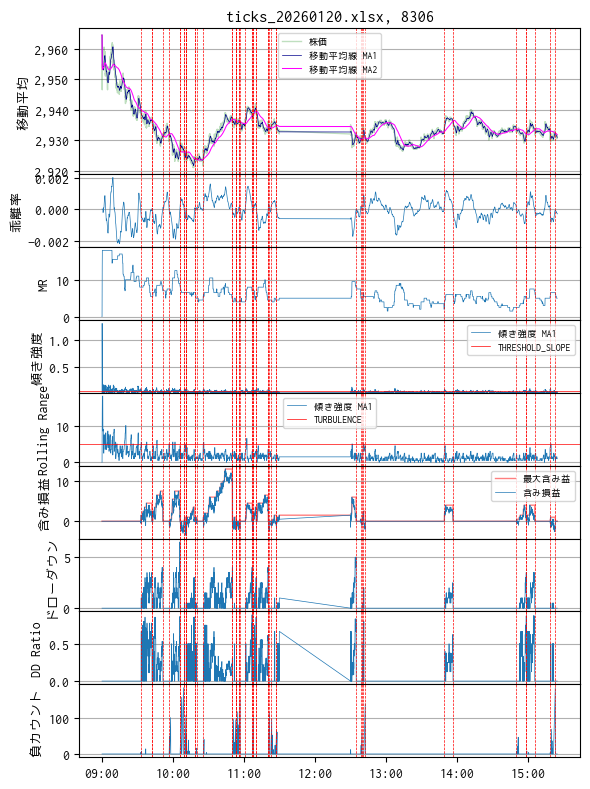

In [9]:
fig = plt.figure(figsize=(6, 8))
n = 9
ax = dict()
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")
ax[0].plot(df_tech["price"], linewidth=1, color="green", alpha=0.25, label="株価")
ax[0].plot(df_tech["ma1"], linewidth=0.5, color="darkblue", label="移動平均線 MA1")
ax[0].plot(df_tech["ma2"], linewidth=0.75, color="magenta", label="移動平均線 MA2")
ax[0].set_ylabel("移動平均")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax[0].legend(fontsize=7)

ax[1].plot(df_tech["disparity"], linewidth=0.5, label="MA乖離率")
ax[1].set_ylabel("乖離率")

ax[2].plot(df_tech["mr"], linewidth=0.5, label="移動範囲")
ax[2].set_ylabel("MR")

ax[3].plot(df_tech["slope1"], linewidth=0.5, label="傾き強度 MA1")
ax[3].axhline(y=THRESHOLD_SLOPE, color="red", linewidth=0.5, label="THRESHOLD_SLOPE")
# ax[3].set_yscale("log")
ax[3].set_ylabel("傾き強度")
ax[3].legend(fontsize=7)
_, y_high = ax[3].get_ylim()
ax[3].set_ylim(0.001, y_high)

ax[4].plot(df_tech["rr"], linewidth=0.5, label="傾き強度 MA1")
ax[4].axhline(y=TURBULENCE, color="red", linewidth=0.5, label="TURBULENCE")
ax[4].set_ylabel("Rolling Range")
ax[4].legend(fontsize=7)

ax[5].plot(
    df_tech["profit_max"], linewidth=1, color="red", alpha=0.5, label="最大含み益"
)
ax[5].plot(df_tech["profit"], linewidth=0.5, color="C0", label="含み損益")
ax[5].set_ylabel("含み損益")
ax[5].legend(fontsize=7)

ax[6].plot(df_tech["drawdown"], linewidth=0.5)
ax[6].set_ylabel("ドローダウン")

ax[7].plot(df_tech["dd_ratio"], linewidth=0.5)
ax[7].set_ylabel("DD Ratio")

ax[8].plot(df_tech["n_minus"], linewidth=0.5)
ax[8].set_ylabel("負カウント")

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_trend_technical.png")
print(output)
plt.savefig(output)
plt.show()

tmp/2026/01/20/8306_hist_slope.png


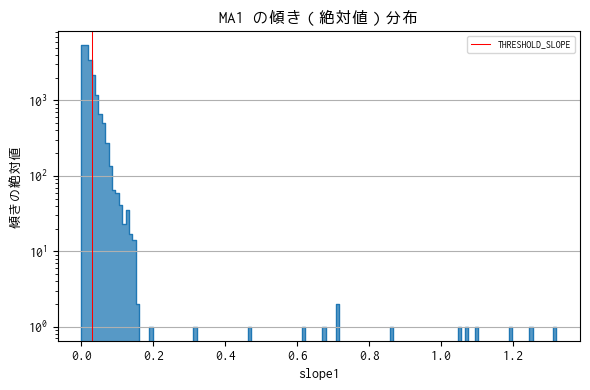

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("MA1 の傾き（絶対値）分布")
sns.histplot(data=df_tech, x="slope1", bins="sqrt", element="step")
ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
ax.set_yscale("log")
ax.set_ylabel("傾きの絶対値")
ax.grid(axis="y")
ax.legend(fontsize=7)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_hist_slope.png")
print(output)
plt.savefig(output)
plt.show()

tmp/2026/01/20/8306_hist_rr.png


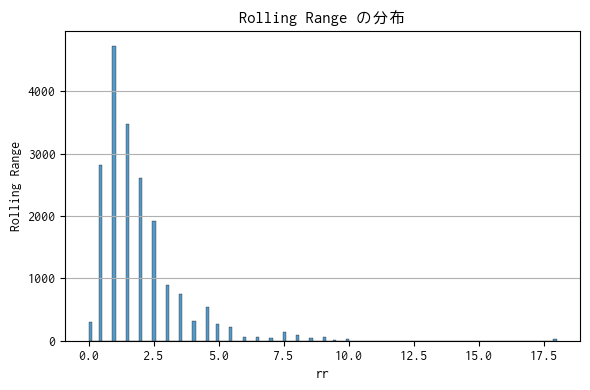

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Rolling Range の分布")
sns.histplot(data=df_tech, x="rr", bins="sqrt")
# ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
# ax.set_yscale("log")
ax.set_ylabel("Rolling Range")
ax.grid(axis="y")
# ax.legend(fontsize=7)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_hist_rr.png")
print(output)
plt.savefig(output)
plt.show()

In [12]:
# 観測値
print("観測値")
df_obs = app.getObservations()
print(df_obs)

観測値
                     クロスS1  クロスS2  クロ強  乱高下  ロス1  ロス2  利確1   建玉
2026-01-20 09:00:10    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-20 09:00:11    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-20 09:00:12    0.0    0.0  0.0  1.0  0.0  0.0  0.0  0.0
2026-01-20 09:00:13    0.0    0.0  0.0  1.0  0.0  0.0  0.0  0.0
2026-01-20 09:00:14    0.0    0.0  0.0  1.0  0.0  0.0  0.0  0.0
...                    ...    ...  ...  ...  ...  ...  ...  ...
2026-01-20 15:24:45    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-20 15:24:46    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-20 15:24:47    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-20 15:24:48    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-20 15:24:49    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0

[19389 rows x 8 columns]


tmp/2026/01/20/8306_trend_obs.png


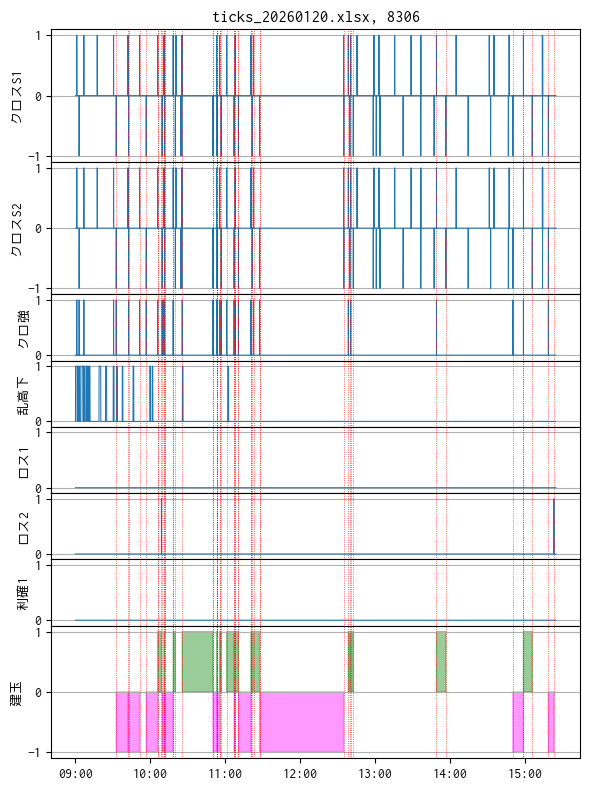

In [13]:
n = len(df_obs.columns)
fig = plt.figure(figsize=(6, n))
ax = dict()

targets = {"クロスS1", "クロスS2", "建玉"}
list_height_ratio = [2 if col in targets else 1 for col in df_obs.columns]
gs = fig.add_gridspec(n, 1, wspace=0.0, hspace=0.0, height_ratios=list_height_ratio)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")

special_cross = {"クロスS1", "クロスS2"}

for i, colname in enumerate(df_obs.columns):
    ax_i = ax[i]

    if colname in special_cross:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-1.1, 1.1)

    elif colname == "建玉":
        x = df_obs.index
        y = df_obs[colname]
        ax_i.fill_between(
            x, 0, y, where=y > 0, color="green", alpha=0.4, interpolate=True
        )
        ax_i.fill_between(
            x, 0, y, where=y < 0, color="magenta", alpha=0.4, interpolate=True
        )
        ax_i.set_ylim(-1.1, 1.1)

    else:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-0.1, 1.1)

    ax_i.set_ylabel(colname)
    ax_i.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dotted", linewidth=0.5)

plt.tight_layout()
output = os.path.join(output_dir, f"{code}_trend_obs.png")
print(output)
plt.tight_layout()
plt.savefig(output)
plt.show()